# Partie 2
## Adapter un modèle pré-entrainé : fine-tuning, Dataset, régularisation

Dans cette seconde partie, nous allons : 
 * Adapter l'architecture d'AlexNet pour un problème de segmentation sémantique d'images satellites,
 * Créer un torch.utils.data.Dataset adapté à notre application,
 * Fine-tuner le modèle,
 * Régulariser le modèle.
 

In [176]:
import rasterio
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [30]:
with rasterio.open('data/UH_NAD83_272056_3289689.tif') as img:
    window = Window(0, 0, 1000, 1000)
    data = img.read(window=window)
    
with rasterio.open('data/2018_IEEE_GRSS_DFC_GT_TR.tif') as gt_:
    gt = np.zeros(img.shape, dtype=np.uint8)
    reproject(
        source=gt_.read(1),
        destination=gt,
        src_transform=gt_.transform,
        src_crs=gt_.crs,
        dst_transform=img.transform,
        dst_crs=img.crs,
        resampling=Resampling.nearest)
    
img = data.transpose(1, 2, 0)
gt = gt[:1000, :1000]
for i, class_id in enumerate(np.unique(gt)):
    gt[class_id == gt] = i

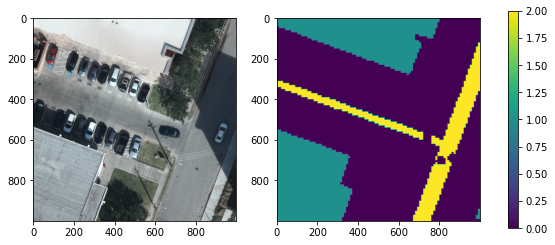

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax1 = ax[1].imshow(gt)
fig.colorbar(ax1, ax=ax, shrink=0.4)
plt.show()

In [89]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, gt, hyperparams):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the spatial neighbourhood
            center_pixel: bool, set to True to consider only the label of the
                          center pixel
            data_augmentation: bool, set to True to perform random flips
            supervision: 'full' or 'semi' supervised algorithms
        """
        super(Dataset, self).__init__()
        self.data = data
        self.label = gt
        self.patch_size = hyperparams["patch_size"]
        self.ignored_labels = set(hyperparams["ignored_labels"])        
        self.height = data.shape[0]
        self.width = data.shape[1]

        mask = np.ones_like(gt)
        for l in self.ignored_labels:
            mask[gt == l] = 0

        x_pos, y_pos = np.nonzero(mask)
        p = self.patch_size // 2
        if p > 0:
            self.indices = np.array(
                [
                    (x, y)
                    for x, y in zip(x_pos, y_pos)
                    if x >= p and x < data.shape[0] - p and y >= p and y < data.shape[1] - p
                ]
            )
        else:
            self.indices = np.array(
                [
                    (x, y)
                    for x, y in zip(x_pos, y_pos)
                ]
            )
            
        self.labels = [self.label[x, y] for x, y in self.indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size

        data = self.data[x1:x2, y1:y2]
        label = self.label[x1:x2, y1:y2]

        # Copy the data into numpy arrays (PyTorch doesn't like numpy views)
        data = np.asarray(np.copy(data).transpose((2, 0, 1)), dtype="float32")
        label = np.asarray(np.copy(label), dtype="int64")

        # Load the data into PyTorch tensors
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        # Extract the center label if needed
        if self.patch_size > 1:
            label = label[self.patch_size // 2, self.patch_size // 2]
        # Remove unused dimensions when we work with invidual spectrums
        elif self.patch_size == 1:
            data = data[:, 0, 0]
            label = label[0, 0]

        return data, label

In [189]:
hyperparams = {'ignored_labels': [0], 'patch_size': 51}
dataset = Dataset(img, gt, hyperparams)
train_dataset, val_dataset = torch.utils.data.random_split(dataset,\
                             [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

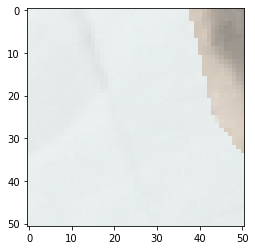

In [91]:
for patch, label in train_loader:
    break
fig = plt.figure()
plt.imshow(patch[30,:,:,:].transpose(2,0)/256)
plt.show()

In [142]:
class TinyAlexNet(AlexNet):
    r""" An AlexNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
      global_params (namedtuple): A set of GlobalParams shared between blocks
    Examples:
        model = AlexNet.from_pretrained("alexnet")
    """

    def __init__(self, global_params=None):
        super().__init__(global_params)

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 1, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Dropout(global_params.dropout_rate),
            nn.Linear(4, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(global_params.dropout_rate),
            nn.Linear(32, global_params.num_classes)
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [193]:
params = get_model_params('alexnet', override_params={'num_classes': 2})
model = TinyAlexNet(params)

In [194]:
pretrained_weights['state_dict'].keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [195]:
model.features[0].weight.data = pretrained_weights['state_dict']['features.0.weight']
model.features[0].bias.data = pretrained_weights['state_dict']['features.0.bias']

In [196]:
type(model.features[0].weight)

torch.nn.parameter.Parameter

In [197]:
model.features[0].weight.requires_grad

True

In [198]:
model.features[0].weight.requires_grad_(False)
model.features[0].bias.requires_grad_(False)
print(model.features[0].weight.requires_grad, model.features[0].bias.requires_grad)

False False


In [209]:
num_epochs = 1
learning_rate = 1e-4
best_val = np.inf
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print('Device is ', device)

Device is  cuda


TinyAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): Identity()
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=4, out_features=32, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [210]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [213]:
for epoch in range(num_epochs):
    y_pred, y_true = [], []
    for patch, label in tqdm(train_loader):
        patch, label = patch.to(device), label.to(device)-1
        logits = model(patch)
        loss = F.cross_entropy(logits, label)
        loss.backward() # Calcul du gradient 
        optimizer.step() # Mise à jour des paramètres
        optimizer.zero_grad() # Mise à zéro du gradient
        
        y_pred.extend(torch.argmax(logits, dim=-1).cpu())
        y_true.extend(label.cpu())
          
    train_accuracy = accuracy_score(y_pred, y_true)
    train_f1 = f1_score(y_pred, y_true)
    
    y_pred, y_true = [], []
    for patch, label in tqdm(val_loader):
        patch, label = patch.to(device), label.to(device)-1
        with torch.no_grad():
            logits = model(patch)
        val_loss = F.cross_entropy(logits, label)
        
        y_pred.extend(torch.argmax(logits, dim=-1).cpu())
        y_true.extend(label.cpu())
        
    val_accuracy = accuracy_score(y_pred, y_true)
    val_f1 = f1_score(y_pred, y_true)
    
    if val_loss.item() < best_val:
        best_val = val_loss.item()
        torch.save({'epoch': epoch, 
                    'best_loss': best_val, 
                    'state_dict': model.state_dict()}, 'alex_net/best_model.pth.tar')
        
    print('[Train] \t Loss: {:.4f} | Accuracy: {:.4f} | F1 score: {:.4f}'.format(\
                                            loss.item(), train_accuracy, train_f1))
    print('[Val] \t Loss: {:.4f} | Accuracy: {:.4f} | F1 score: {:.4f}'.format(\
                                          val_loss.item(), val_accuracy, val_f1))

100%|██████████| 237/237 [00:03<00:00, 62.65it/s]


[Train] 	 Loss: 0.1128 | Accuracy: 0.9706 | F1 score: 0.9494
[Val] 	 Loss: 0.0970 | Accuracy: 0.9734 | F1 score: 0.9542


In [214]:
def regularization(model, norm="L2"):
    L = 0
    for param in model.parameters():
        if norm == "L2":
            L += torch.linalg.norm(param, dim=-1).mean()
        elif norm == "L1":
            L += torch.sum(torch.abs(param), dim=-1).mean()
        else:
            raise NotImplementedError
    return L   

In [215]:
regularization(model.classifier)

tensor(2.2958, device='cuda:0', grad_fn=<AddBackward0>)